###Installation silencieuse de scikit-learn, la boîte à outils incontournable pour le machine learning en Python

In [ ]:
!pip install -q scikit-learn

####Montage de votre Google Drive dans l’environnement Colab pour accéder directement à vos fichiers stockés dans le cloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🔧 1. Imports : Chargement des modules indispensables pour la gestion de fichiers, le traitement d’images, et la création de modèles PyTorch \
📁 2. Chemins des datasets : Définition des répertoires d’entraînement, de validation et de test sur votre Google Drive \
🌀 3. Transformations : Mise en place des transformations (redimensionnement et conversion en tenseur) à appliquer à chaque image\
🛠️ 4. Helpers : Définition de fonctions utilitaires pour lister récursivement les fichiers images et extraire le label depuis le nom de fichier \
🧾 5. Dataset personnalisé : Création d’une classe PyTorch Dataset qui ouvre, nettoie (patch noir si corrompue), transforme et encode les images et leurs labels \
📖​6. Construction des fichiers & LabelEncoder unique : Récupération des chemins d’images pour chaque split et encodage des labels avec un seul LabelEncoder entraîné sur les données d’entraînement \
🧠 7. Modèle ResNet34 : Initialisation d’un ResNet34 pré-entraîné, adaptation de sa couche finale au nombre de classes et transfert sur GPU ou CPU
⏱️ 8. Early-Stopping : Implémentation d’un mécanisme d’arrêt anticipé qui sauve le meilleur modèle et stoppe l’entraînement en cas de stagnation
🚀 9. Boucle d’entraînement : Exécution de l’entraînement et de la validation à chaque époque, suivi du scheduler de learning rate et du early-stopping
🏁 10. Chargement & prédiction : Chargement du meilleur modèle sauvegardé et définition d’une fonction utilitaire pour prédire la classe et la confiance d’une image


In [ ]:
# ============================================================
# 🔧 1. Imports
# ============================================================
import os, glob, imghdr, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from PIL import Image, UnidentifiedImageError
import numpy as np

# ============================================================
# 📁 2. Chemins des datasets
# ============================================================
BASE_DIR = '/content/drive/MyDrive/ResNet/Resnet_dataset'
TRAIN_DIR, VAL_DIR, TEST_DIR = [os.path.join(BASE_DIR, d) for d in ('train', 'val', 'test')]

# ============================================================
# 🌀 3. Transformations
# ============================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ============================================================
# 🛠️ 4. Helpers : collecte récursive et extraction du label
# ============================================================
def list_images_recursively(folder):
    """Renvoie tous les chemins d’images valides (toutes extensions) sous `folder`."""
    candidates = glob.glob(os.path.join(folder, '**', '*.*'), recursive=True)
    return [f for f in candidates if imghdr.what(f) is not None]

def extract_label(path):
    """Extrait le préfixe-classe avant le premier '_'."""
    return os.path.basename(path).split('_')[0].strip()

# ============================================================
# 🧾 5. Dataset personnalisé
# ============================================================
class MotifDataset(Dataset):
    def __init__(self, file_list, label_encoder, transform=None):
        self.files      = file_list
        self.le         = label_encoder
        self.transform  = transform
        self.labels_enc = self.le.transform([extract_label(f) for f in self.files])

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        path  = self.files[idx]
        try:
            img = Image.open(path).convert('RGB')
        except (UnidentifiedImageError, OSError):
            # Image corrompue : on renvoie un patch noir
            img = Image.new('RGB', (224, 224))
        if self.transform:
            img = self.transform(img)
        label = int(self.labels_enc[idx])
        return img, label

# ============================================================
# 📖​ 6. Construction des fichiers & LabelEncoder unique
# ============================================================
train_files = list_images_recursively(TRAIN_DIR)
val_files   = list_images_recursively(VAL_DIR)
test_files  = list_images_recursively(TEST_DIR)

train_labels = [extract_label(f) for f in train_files]
LE = LabelEncoder().fit(train_labels)

# Datasets / DataLoaders
train_ds = MotifDataset(train_files, LE, transform)
val_ds   = MotifDataset(val_files,   LE, transform)
test_ds  = MotifDataset(test_files,  LE, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# ============================================================
# 🧠 7. Modèle ResNet34
# ============================================================
NUM_CLASSES = len(LE.classes_)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# ============================================================
# ⏱️ 8. Early-Stopping
# ============================================================
class EarlyStopping:
    def __init__(self, patience=10, mode='max', delta=0., path='best_resnet34.pth'):
        self.patience, self.mode, self.delta, self.path = patience, mode, delta, path
        self.best_score, self.counter, self.early_stop = None, 0, False

    def __call__(self, metric, model):
        score = metric if self.mode == 'max' else -metric
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score, self.counter = score, 0
            torch.save(model.state_dict(), self.path)
            print(f'  🔸 Nouveau meilleur modèle sauvegardé ({metric:.4f})')
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ============================================================
# 🚀 9. Boucle d’entraînement
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.3, verbose=True)

stopper  = EarlyStopping(patience=10, mode='max', path='best_resnet34.pth')
EPOCHS   = 100

for epoch in range(1, EPOCHS + 1):
    # ---------- Train ----------
    model.train(); running_loss = 0.
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward(); optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    # ---------- Validation ----------
    model.eval(); correct = total = val_loss = 0.
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            val_loss += criterion(out, y).item()
            _, pred = torch.max(out, 1)
            total   += y.size(0)
            correct += (pred == y).sum().item()
    val_loss /= len(val_loader)
    val_acc   = 100 * correct / total

    print(f'Epoch {epoch:03}/{EPOCHS} | '
          f'Train {train_loss:.4f} | Val {val_loss:.4f} | Acc {val_acc:.2f}%')

    scheduler.step(val_acc)
    stopper(val_acc, model)
    if stopper.early_stop:
        print(f'⏹️  Early-Stopping déclenché à l’époque {epoch}.')
        break

# ============================================================
# 🏁 10. Chargement du meilleur modèle & prédiction rapide
# ============================================================
best_model = models.resnet34(weights=None)
best_model.fc = nn.Linear(best_model.fc.in_features, NUM_CLASSES)
best_model.load_state_dict(torch.load('best_resnet34.pth'))
best_model = best_model.to(DEVICE).eval()

def predict_image(path):
    img = Image.open(path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = best_model(tensor)
        probs  = torch.softmax(logits, dim=1).squeeze(0)
        conf, idx = torch.max(probs, 0)
    return LE.inverse_transform([idx.cpu().item()])[0], conf.item()

# Exemple d’utilisation :
# label, p = predict_image('/content/drive/MyDrive/ResNet/Resnet_dataset/test/9003_abc.png')
# print(f'{label} ({p*100:.1f} %)')


<ipython-input-3-dd6d7de0ddaf>:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import os, glob, imghdr, torch, torch.nn as nn
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 159MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001/100 | Train 3.8891 | Val 3.1369 | Acc 29.81%
  🔸 Nouveau meilleur modèle sauvegardé (29.8067)
Epoch 002/100 | Train 2.1573 | Val 2.5394 | Acc 43.85%
  🔸 Nouveau meilleur modèle sauvegardé (43.8454)
Epoch 003/100 | Train 1.1472 | Val 2.2184 | Acc 49.64%
  🔸 Nouveau meilleur modèle sauvegardé (49.6439)
Epoch 004/100 | Train 0.5445 | Val 1.9436 | Acc 54.12%
  🔸 Nouveau meilleur modèle sauvegardé (54.1200)
Epoch 005/100 | Train 0.2533 | Val 1.8960 | Acc 56.05%
  🔸 Nouveau meilleur modèle sauvegardé (56.0529)
Epoch 006/100 | Train 0.1294 | Val 1.7594 | Acc 60.43%
  🔸 Nouveau meilleur modèle sauvegardé (60.4273)
Epoch 007/100 | Train 0.0713 | Val 1.7096 | Acc 60.73%
  🔸 Nouveau meilleur modèle sauvegardé (60.7325)
Epoch 008/100 | Train 0.0463 | Val 1.6814 | Acc 59.72%
Epoch 009/100 | Train 0.0402 | Val 1.6687 | Acc 59.82%
Epoch 010/100 | Train 0.0247 | Val 1.6651 | Acc 61.75%
  🔸 Nouveau meilleur modèle sauvegardé (61.7497)
Epoch 011/100 | Train 0.0223 | Val 1.7485 | Acc 58.90%
Epo

🎯 Évaluation complète du modèle sur le jeu de validation :
     - Calcul de la précision globale pour avoir un aperçu rapide \
     - Affichage du rapport de classification détaillé (précision, rappel, F1) \
     - Visualisation de la matrice de confusion pour voir où ça coince 🧩\
     - Analyse des erreurs majeures (classes <50 % de précision) 🔎\
     - Affichage du taux de reconnaissance par classe pour clore 📊



🎯 Précision globale sur validation : 67.34%

📄 Rapport de classification :
              precision    recall  f1-score   support

           1       0.61      0.61      0.61        18
        1001       0.92      0.92      0.92        13
        1002       0.00      0.00      0.00         2
        1003       0.00      0.00      0.00        10
        1004       0.48      0.83      0.61        18
        1005       0.62      0.70      0.66        33
        1006       0.60      0.55      0.57        11
        1007       1.00      1.00      1.00         1
        1008       0.00      0.00      0.00         1
        1009       1.00      0.50      0.67         6
        1010       0.74      0.82      0.78        17
        1011       1.00      1.00      1.00         1
        1012       0.58      0.85      0.69        13
        1013       0.00      0.00      0.00         3
        1014       0.25      0.25      0.25         4
        1015       0.60      0.50      0.55         6
     

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


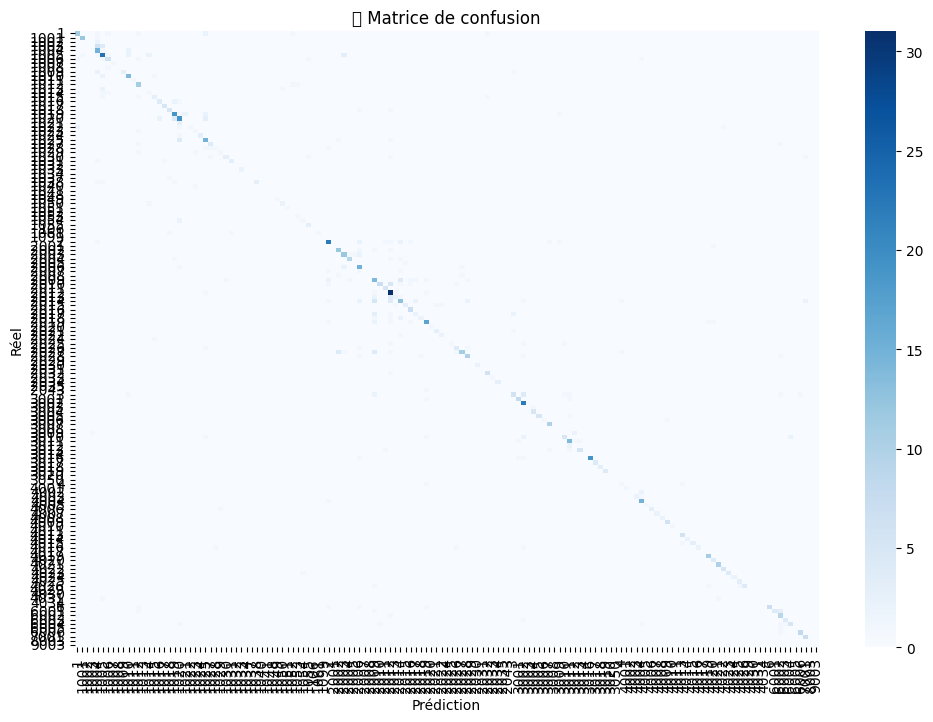


🔎 Analyse des erreurs majeures (classes avec < 50 % de précision)

⚠️ Classe 1002 mal classée à 0.00% (0/2)
   → Confondue 2 fois (100.0 %) avec la classe 1004
⚠️ Classe 1003 mal classée à 0.00% (0/10)
   → Confondue 6 fois (60.0 %) avec la classe 1004
⚠️ Classe 1008 mal classée à 0.00% (0/1)
   → Confondue 1 fois (100.0 %) avec la classe 1006
⚠️ Classe 1013 mal classée à 0.00% (0/3)
   → Confondue 2 fois (66.7 %) avec la classe 1005
⚠️ Classe 1014 mal classée à 25.00% (1/4)
   → Confondue 1 fois (25.0 %) avec la classe 1
⚠️ Classe 1021 mal classée à 0.00% (0/3)
   → Confondue 3 fois (100.0 %) avec la classe 1020
⚠️ Classe 1022 mal classée à 20.00% (1/5)
   → Confondue 2 fois (40.0 %) avec la classe 1
⚠️ Classe 1028 mal classée à 25.00% (1/4)
   → Confondue 1 fois (25.0 %) avec la classe 1025
⚠️ Classe 1029 mal classée à 33.33% (1/3)
   → Confondue 1 fois (33.3 %) avec la classe 1012
⚠️ Classe 1030 mal classée à 42.86% (3/7)
   → Confondue 1 fois (14.3 %) avec la classe 1027
⚠️ Classe

In [ ]:
# ============================================================
# 📊 8. Évaluation complète (validation)
# ============================================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ---------- précision globale ----------
accuracy = 100 * (y_true == y_pred).sum() / len(y_true)
print(f"\n🎯 Précision globale sur validation : {accuracy:.2f}%")

# ---------- classes & rapports ----------
all_classes = LE.inverse_transform(np.arange(NUM_CLASSES))      # toutes les classes
print("\n📄 Rapport de classification :")
print(classification_report(
        y_true, y_pred,
        labels=np.arange(NUM_CLASSES),
        target_names=all_classes.astype(str),
        zero_division=0))

# ---------- matrice de confusion ----------
cm = confusion_matrix(y_true, y_pred, labels=np.arange(NUM_CLASSES))

plt.figure(figsize=(min(1.2*NUM_CLASSES, 12), min(0.8*NUM_CLASSES, 8)))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("🧩 Matrice de confusion")
plt.show()

# ============================================================
# ❌ Analyse d'erreur approfondie
# ============================================================
print("\n🔎 Analyse des erreurs majeures (classes avec < 50 % de précision)\n")

for idx, label in enumerate(all_classes):
    total_cls    = cm[idx].sum()
    correct_cls  = cm[idx, idx]

    if total_cls == 0:
        continue  # aucune image de cette classe dans le set val

    acc_cls = 100 * correct_cls / total_cls
    if acc_cls < 50:
        # recherche de la confusion dominante
        conf_vec = cm[idx].copy()
        conf_vec[idx] = 0
        if conf_vec.sum() == 0:
            print(f"⚠️ Classe {label} mal classée à {acc_cls:.2f}% "
                  f"({correct_cls}/{total_cls}) — aucune confusion dominante.")
            continue

        worst_idx = conf_vec.argmax()
        worst_lab = all_classes[worst_idx]
        worst_cnt = conf_vec[worst_idx]
        worst_pct = 100 * worst_cnt / total_cls

        print(f"⚠️ Classe {label} mal classée à {acc_cls:.2f}% "
              f"({correct_cls}/{total_cls})")
        print(f"   → Confondue {worst_cnt} fois ({worst_pct:.1f} %) "
              f"avec la classe {worst_lab}")

# ---------- taux de reconnaissance par classe ----------
print("\n📊 Taux de reconnaissance par classe :")
for idx, label in enumerate(all_classes):
    total_cls   = cm[idx].sum()
    correct_cls = cm[idx, idx]
    rate = 100 * correct_cls / total_cls if total_cls > 0 else 0
    print(f"Classe {label} : {rate:.2f}% ({correct_cls}/{total_cls})")


🧩 Évaluation par classe « mère » : \
     - Définition de la "classe mère" (premier caractère du préfixe) via get_mother_class() \
     - Conversion de y_true/y_pred en étiquettes texte puis extraction des classes mères \
     - Construction et affichage de la matrice de confusion des classes mères pour visualiser les confusions \
     - Calcul et affichage du taux de reconnaissance pour chaque classe mère \
     - Calcul de la précision globale sur l’ensemble des classes mères 🌍



🧬 Matrice de confusion des classes « mères » :


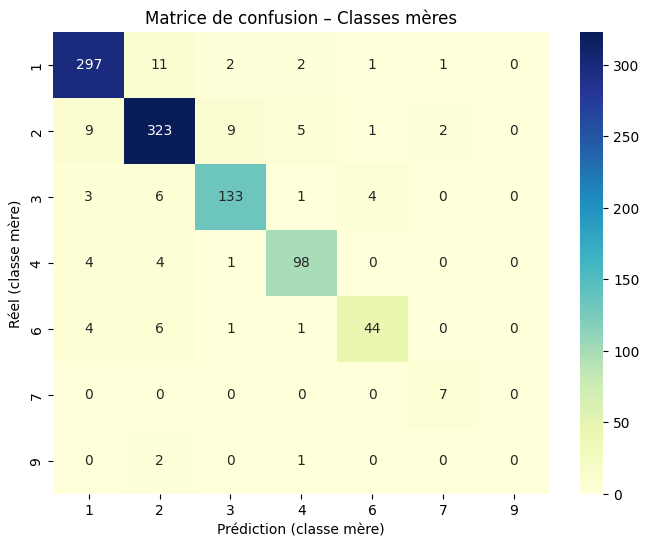


📊 Taux de reconnaissance par classe mère :
Classe mère 1 : 94.59% (297/314)
Classe mère 2 : 92.55% (323/349)
Classe mère 3 : 90.48% (133/147)
Classe mère 4 : 91.59% (98/107)
Classe mère 6 : 78.57% (44/56)
Classe mère 7 : 100.00% (7/7)
Classe mère 9 : 0.00% (0/3)

🌍 Précision globale (classes mères) : 91.76%


In [ ]:
# ============================================================
# 🧩 Évaluation par classe « mère »
# ============================================================
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. fonction utilitaire : la "mère" est le 1er chiffre du préfixe ---
def get_mother_class(label_str: str) -> str:
    """
    Prend '9003' -> '9'
    (modifie ici si ta définition change : par ex. les 2 premiers caractères)
    """
    return label_str.strip()[0]

# --- 2. conversion des y_true / y_pred (indices) en étiquettes texte ---
labels_true_str = LE.inverse_transform(y_true)   # tableau de chaînes '9003', '7002', ...
labels_pred_str = LE.inverse_transform(y_pred)

# --- 3. extraction des classes mères ---
y_true_mother = [get_mother_class(lbl) for lbl in labels_true_str]
y_pred_mother = [get_mother_class(lbl) for lbl in labels_pred_str]

mother_classes = sorted(set(y_true_mother + y_pred_mother))

# --- 4. matrice de confusion mère ---
cm_mother = confusion_matrix(y_true_mother,
                             y_pred_mother,
                             labels=mother_classes)

print("\n🧬 Matrice de confusion des classes « mères » :")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mother,
            annot=True,
            fmt="d",
            cmap="YlGnBu",
            xticklabels=mother_classes,
            yticklabels=mother_classes)
plt.xlabel("Prédiction (classe mère)")
plt.ylabel("Réel (classe mère)")
plt.title("Matrice de confusion – Classes mères")
plt.show()

# --- 5. taux de reconnaissance par classe mère ---
print("\n📊 Taux de reconnaissance par classe mère :")
for i, m_lbl in enumerate(mother_classes):
    total   = cm_mother[i].sum()
    correct = cm_mother[i, i]
    rate    = 100 * correct / total if total > 0 else 0
    print(f"Classe mère {m_lbl} : {rate:.2f}% ({correct}/{total})")

# --- 6. précision globale sur les classes mères ---
global_mother_acc = 100 * np.trace(cm_mother) / cm_mother.sum()
print(f"\n🌍 Précision globale (classes mères) : {global_mother_acc:.2f}%")


 💾 Sauvegarde versionnée :\
     - Création d’un timestamp pour différencier chaque itération \
     - Préparation du dossier de sortie sur Google Drive \
     - Définition des chemins pour : \
        &emsp;&emsp;&emsp;&emsp;&emsp; • les poids (state_dict) – compact ✅  
        &emsp;&emsp;&emsp;&emsp;&emsp; • le modèle complet (optionnel)  
        &emsp;&emsp;&emsp;&emsp;&emsp; • le LabelEncoder (pkl)  
     - Enregistrement des poids et du LabelEncoder pour réutilisation ultérieure


In [ ]:
import os, joblib, datetime, torch
# 2) Dossier de sortie
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')
SAVE_DIR  = '/content/drive/MyDrive/ResNet/saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

# 3) Chemins de fichiers
weights_path = os.path.join(SAVE_DIR, f'best_resnet34_weights_{timestamp}.pth')
model_path   = os.path.join(SAVE_DIR, f'best_resnet34_full_{timestamp}.pth')
le_path      = os.path.join(SAVE_DIR, f'label_encoder_{timestamp}.pkl')

# 4) Poids (state_dict) – léger
torch.save(best_model.state_dict(), weights_path)
print(f'✅ Poids sauvegardés : {weights_path}')

# 5) Modèle complet (structure + poids) – plus gros, optionnel
#    Décommente la ligne suivante si tu en as besoin
# torch.save(best_model, model_path)
# print(f'✅ Modèle complet sauvegardé : {model_path}')

# 6) LabelEncoder pour retrouver les noms de classes
joblib.dump(LE, le_path)
print(f'✅ LabelEncoder sauvegardé : {le_path}')

✅ Poids sauvegardés : /content/drive/MyDrive/ResNet/saved_models/best_resnet34_weights_20250609_1732.pth
✅ LabelEncoder sauvegardé : /content/drive/MyDrive/ResNet/saved_models/label_encoder_20250609_1732.pkl


In [ ]:
# ============================================================
# 0)  Config
# ============================================================
IMAGES_DIR  = '/content/drive/MyDrive/Last_Train/data/test/images'
PRED_LABELS = '/content/drive/MyDrive/Last_Train/val/exp/labels'   # .txt YOLO
RESNET_W    = '/content/drive/MyDrive/ResNet/saved_models/best_resnet34_weights_20250609_1732.pth'
LE_PATH     = '/content/drive/MyDrive/ResNet/saved_models/label_encoder_20250609_1732.pkl'

EXCEL_OUT   = 'resnet_predictions.xlsx'

# ============================================================
# 1)  Imports & modèle
# ============================================================
import os, glob, joblib, cv2, torch
import numpy as np, pandas as pd
from PIL import Image
from torchvision import transforms, models
from tqdm.auto import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

LE = joblib.load(LE_PATH)
NUM_CLASSES = len(LE.classes_)

resnet = models.resnet34(weights=None)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, NUM_CLASSES)
resnet.load_state_dict(torch.load(RESNET_W, map_location=DEVICE))
resnet = resnet.to(DEVICE).eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def find_image(basename: str):
    matches = glob.glob(os.path.join(IMAGES_DIR, basename + '.*'))
    return matches[0] if matches else None

# ============================================================
# 2)  Boucle prédictions YOLO → ResNet
# ============================================================
rows = []
for pred_txt in tqdm(sorted(glob.glob(os.path.join(PRED_LABELS, '*.txt'))), desc="YOLO→ResNet"):
    basename = os.path.splitext(os.path.basename(pred_txt))[0]
    img_path = find_image(basename)
    if img_path is None:
        continue

    img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    with open(pred_txt) as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            if len(parts) < 6:
                continue
            yolo_cls_id, cx, cy, bw, bh, yolo_conf = parts

            # -------- crop avec coordonnées absolues pour ResNet --------
            H, W, _ = img_rgb.shape
            x1 = int((cx - bw/2) * W); x2 = int((cx + bw/2) * W)
            y1 = int((cy - bh/2) * H); y2 = int((cy + bh/2) * H)
            roi = img_rgb[max(y1,0):max(y2,0), max(x1,0):max(x2,0)]
            if roi.size == 0:
                continue

            tensor = transform(Image.fromarray(roi)).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                logits = resnet(tensor)
                probs  = torch.softmax(logits, 1).squeeze(0)
                top5_prob, top5_idx = torch.topk(probs, k=5)

            top5_labels = LE.inverse_transform(top5_idx.cpu().numpy())
            top5_confs  = top5_prob.cpu().numpy()

            rows.append({
                'image'            : os.path.basename(img_path),
                'cx'               : cx,   # ------------------------------
                'cy'               : cy,   #  coordonnées YOLO normalisées
                'w'                : bw,   # ------------------------------
                'h'                : bh,
                'yolo_cls'         : int(yolo_cls_id),
                'yolo_conf'        : float(yolo_conf),
                'resnet_top1_cls'  : str(top5_labels[0]),
                'resnet_top1_conf' : float(top5_confs[0]),
                'resnet_top5_cls'  : ';'.join(map(str, top5_labels)),
                'resnet_top5_conf' : ';'.join(f"{p:.3f}" for p in top5_confs)
            })

# ============================================================
# 3)  Export Excel
# ============================================================
df_out = pd.DataFrame(rows)
df_out.to_excel(EXCEL_OUT, index=False)
print(f"✅ Fichier Excel créé : {EXCEL_OUT}  ({len(df_out)} lignes)")


YOLO→ResNet:   0%|          | 0/375 [00:00<?, ?it/s]

✅ Fichier Excel créé : resnet_predictions.xlsx  (9010 lignes)


Matching IoU:   0%|          | 0/1502 [00:00<?, ?it/s]


✅ Fichier enrichi : resnet_predictions_matched3.xlsx  (1502 lignes)


,image,gt_boxes,pred_boxes,matched_boxes,recall_gt
0,2023-559.JPG,3,3,3,1.0
1,2023-562.JPG,2,2,1,0.5
2,2023-563.JPG,1,4,2,1.0
3,2023-572.JPG,1,2,0,0.0
4,2023-589.JPG,2,2,2,1.0



📈 Recall moyen (GT couvert) : 96.70%

📄 Rapport de classification (fines) :
              precision    recall  f1-score   support

           1       0.69      0.65      0.67        17
        1001       1.00      1.00      1.00         6
        1003       0.00      0.00      0.00         2
        1004       0.85      0.96      0.90        23
        1005       0.72      0.82      0.77        22
        1006       0.71      0.28      0.40        18
        1007       0.00      0.00      0.00         4
        1009       0.00      0.00      0.00         1
        1010       0.60      1.00      0.75        15
        1011       1.00      0.20      0.33         5
        1012       0.69      0.47      0.56        19
        1013       0.71      1.00      0.83         5
        1014       0.88      0.88      0.88         8
        1015       0.83      1.00      0.91         5
        1016       0.40      0.29      0.33        14
        1017       0.25      0.67      0.36         3
    

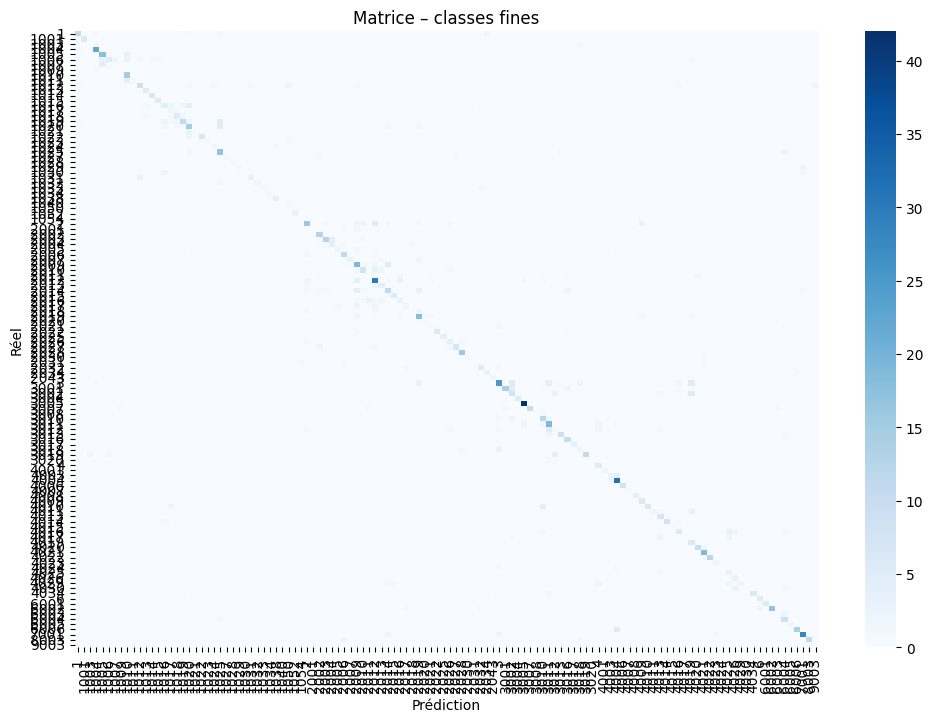

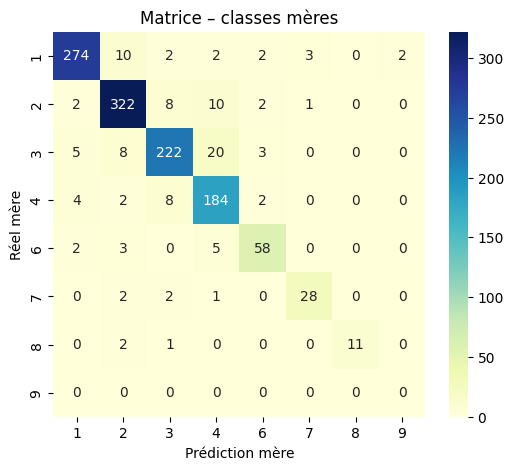

In [ ]:
# ============================================================
# 0)  Chemins et hyper-paramètres
# ============================================================
PRED_EXCEL = 'resnet_predictions.xlsx'                           # prédictions ResNet+YOLO
GT_XLSX    = '/content/drive/MyDrive/Last_Train/data_final.xlsx' # GT fines (Excel)
IOU_THRESH = 0.50                                                # seuil d’appariement
OUT_EXCEL  = 'resnet_predictions_matched3.xlsx'                   # fichier enrichi

# ============================================================
# 1)  Imports
# ============================================================
import os, pandas as pd, numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt, seaborn as sns

# silence pandas FutureWarnings
import warnings; warnings.filterwarnings("ignore", category=FutureWarning)

# ------------------------------------------------------------
def cxcywh_to_xyxy(cx, cy, w, h):
    return cx - w/2, cy - h/2, cx + w/2, cy + h/2

def iou_xyxy(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    inter = max(xB - xA, 0) * max(yB - yA, 0)
    if inter == 0: return 0.0
    areaA = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    return inter / (areaA + areaB - inter)

mother = lambda s: str(s).strip()[0]

# ============================================================
# 2)  Lecture et pré-filtrage
# ============================================================
df_pred = pd.read_excel(PRED_EXCEL)
df_pred = df_pred[df_pred['yolo_conf'] >= 0.01].reset_index(drop=True)

df_gt = pd.read_excel(GT_XLSX).rename(columns=str.lower)
df_gt['basename'] = df_gt['image'].apply(lambda p: os.path.splitext(p)[0])
gt_group = {bn: grp for bn, grp in df_gt.groupby('basename')}

# listes → confusion matrices
y_true_f, y_pred_f = [], []

# colonnes à créer
for col in ['cx_gt','cy_gt','w_gt','h_gt','fine_class_gt',
            'mother_pred','mother_gt',
            'classe_trouve','mère_trouve','matched']:
    df_pred[col] = np.nan

# ============================================================
# 3)  Appariement IoU + complétion
# ============================================================
for idx, row in tqdm(df_pred.iterrows(),
                     total=len(df_pred), desc='Matching IoU'):
    bn = os.path.splitext(row['image'])[0]
    if bn not in gt_group:
        df_pred.at[idx, 'matched'] = 0
        continue

    # boîte prédite (normalisée)
    b_pred = cxcywh_to_xyxy(row.cx, row.cy, row.w, row.h)

    # cherche la GT de meilleur IoU
    best_iou, best_row = 0.0, None
    for _, gt in gt_group[bn].iterrows():
        b_gt = cxcywh_to_xyxy(gt.cx, gt.cy, gt.w, gt.h)
        i = iou_xyxy(b_pred, b_gt)
        if i > best_iou:
            best_iou, best_row = i, gt

    if best_iou < IOU_THRESH or best_row is None:
        df_pred.at[idx, 'matched'] = 0
        continue

    # ------------------- matched -------------------
    df_pred.at[idx, 'matched'] = 1
    df_pred.loc[idx, ['cx_gt','cy_gt','w_gt','h_gt']] \
        = best_row[['cx','cy','w','h']]

    fine_gt = str(int(best_row['fine_class']))    # ex '9003'
    df_pred.at[idx, 'fine_class_gt'] = fine_gt

    mother_pred = mother(row['resnet_top1_cls'])
    mother_gt   = mother(fine_gt)

    df_pred.at[idx, 'mother_pred'] = mother_pred
    df_pred.at[idx, 'mother_gt']   = mother_gt

    top5_list = str(row['resnet_top5_cls']).split(';')
    df_pred.at[idx, 'classe_trouve'] = int(fine_gt in top5_list)
    df_pred.at[idx, 'mère_trouve']   = int(mother_pred == mother_gt)

    # listes pour confusion (tout en str)
    y_true_f.append(fine_gt)
    y_pred_f.append(str(row['resnet_top1_cls']))

# ============================================================
# 4)  Sauvegarde Excel enrichi
# ============================================================
df_pred.to_excel(OUT_EXCEL, index=False)
print(f"\n✅ Fichier enrichi : {OUT_EXCEL}  ({len(df_pred)} lignes)")

# ============================================================
# 5)  Récapitulatif par image
# ============================================================
summary = []
for img, grp in df_pred.groupby('image'):
    nb_pred  = len(grp)
    nb_match = int(grp['matched'].sum())
    nb_gt    = len(gt_group.get(os.path.splitext(img)[0], []))
    recall_gt = min(nb_match, nb_gt) / nb_gt if nb_gt else np.nan
    summary.append((img, nb_gt, nb_pred, nb_match, recall_gt))

df_sum = pd.DataFrame(summary,
                      columns=['image','gt_boxes','pred_boxes',
                               'matched_boxes','recall_gt'])

display(df_sum.head())         # top 5 lignes
print(f"\n📈 Recall moyen (GT couvert) : "
      f"{df_sum['recall_gt'].mean(skipna=True)*100:.2f}%")

# ============================================================
# 6)  Matrices de confusion
# ============================================================
if y_true_f:
    y_true_f = list(map(str, y_true_f))
    y_pred_f = list(map(str, y_pred_f))
    present  = sorted(set(y_true_f) | set(y_pred_f))

    cm = confusion_matrix(y_true_f, y_pred_f, labels=present)
    print("\n📄 Rapport de classification (fines) :")
    print(classification_report(y_true_f, y_pred_f,
                                labels=present, target_names=present,
                                zero_division=0))

    plt.figure(figsize=(min(12,1.2*len(present)), min(8,0.8*len(present))))
    sns.heatmap(cm, cmap='Blues',
                xticklabels=present, yticklabels=present)
    plt.xlabel('Prédiction'); plt.ylabel('Réel')
    plt.title('Matrice – classes fines')
    plt.show()

    y_true_m = [mother(x) for x in y_true_f]
    y_pred_m = [mother(x) for x in y_pred_f]
    mothers  = sorted(set(y_true_m) | set(y_pred_m))

    cm_m = confusion_matrix(y_true_m, y_pred_m, labels=mothers)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_m, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=mothers, yticklabels=mothers)
    plt.xlabel('Prédiction mère'); plt.ylabel('Réel mère')
    plt.title('Matrice – classes mères')
    plt.show()
else:
    print("\n⚠️  Aucun appariement IoU ≥ 0.5 : matrices non calculées.")


matching:   0%|          | 0/1502 [00:00<?, ?it/s]


✅ Fichier enrichi : resnet_predictions_matched5.xlsx  (1502 lignes)

📊  Récapitulatif par image (top 5) :


,image,gt_boxes,pred_boxes,matched_boxes,recall_gt
0,2023-559.JPG,3,3,3,1.0
1,2023-562.JPG,2,2,1,0.5
2,2023-563.JPG,1,4,2,1.0
3,2023-572.JPG,1,2,0,0.0
4,2023-589.JPG,2,2,2,1.0



Moyenne recall (GT couvert) : 96.70%

📄 Rapport (fines) :
              precision    recall  f1-score   support

           1       0.69      0.65      0.67        17
        1001       1.00      1.00      1.00         6
        1003       0.00      0.00      0.00         2
        1004       0.85      0.96      0.90        23
        1005       0.72      0.82      0.77        22
        1006       0.71      0.28      0.40        18
        1007       0.00      0.00      0.00         4
        1009       0.00      0.00      0.00         1
        1010       0.60      1.00      0.75        15
        1011       1.00      0.20      0.33         5
        1012       0.69      0.47      0.56        19
        1013       0.71      1.00      0.83         5
        1014       0.88      0.88      0.88         8
        1015       0.83      1.00      0.91         5
        1016       0.40      0.29      0.33        14
        1017       0.25      0.67      0.36         3
        1018       0.5

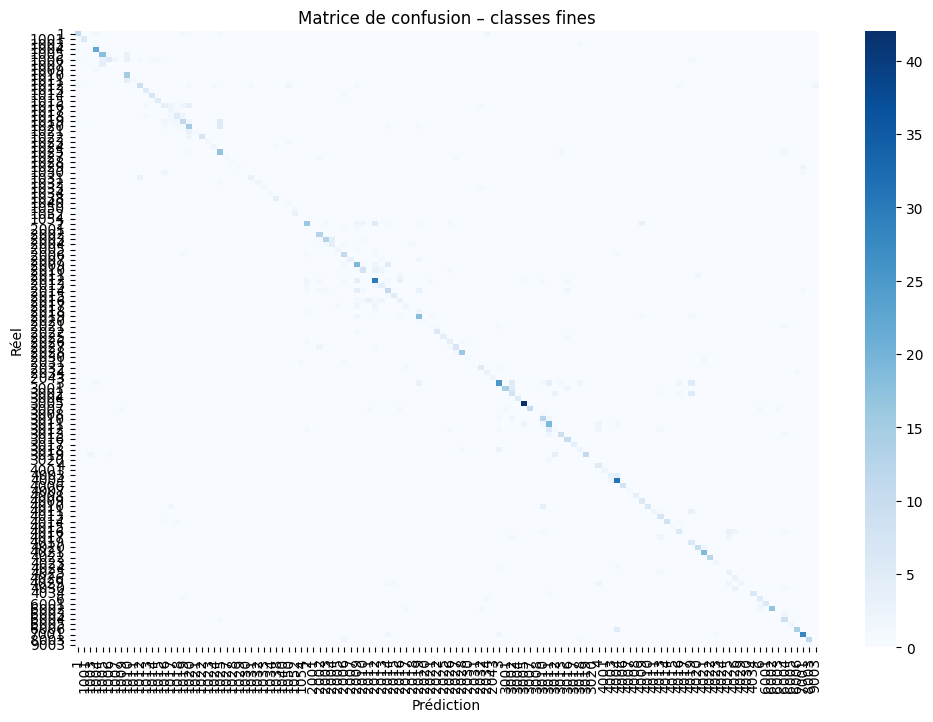


📄 Rapport (classes mères) :
              precision    recall  f1-score   support

           1       0.95      0.93      0.94       295
           2       0.92      0.93      0.93       345
           3       0.91      0.86      0.89       258
           4       0.83      0.92      0.87       200
           6       0.87      0.85      0.86        68
           7       0.88      0.85      0.86        33
           8       1.00      0.79      0.88        14
           9       0.00      0.00      0.00         0

    accuracy                           0.91      1213
   macro avg       0.80      0.77      0.78      1213
weighted avg       0.91      0.91      0.91      1213

Accuracy global mères : 90.60%


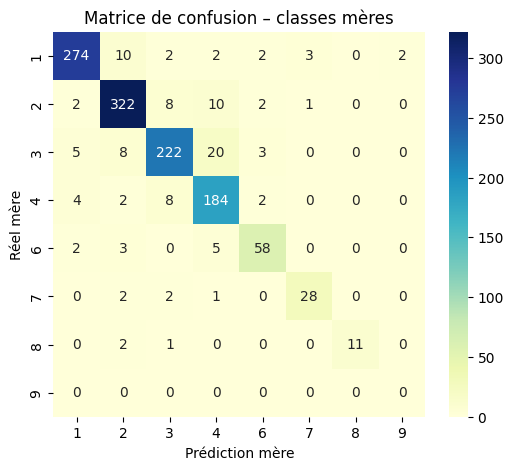

In [ ]:
# ============================================================
# 0)  Chemins & paramètres
# ============================================================
PRED_EXCEL = 'resnet_predictions.xlsx'                           # prédictions ResNet+YOLO
GT_XLSX    = '/content/drive/MyDrive/Last_Train/data_final.xlsx' # GT fines
IOU_THRESH = 0.50
OUT_EXCEL  = 'resnet_predictions_matched5.xlsx'

# ============================================================
# 1)  Imports
# ============================================================
import os, pandas as pd, numpy as np, warnings
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

# ============================================================
# 2)  Fonctions utilitaires
# ============================================================
def cxcywh_to_xyxy(cx, cy, w, h):
    return cx - w/2, cy - h/2, cx + w/2, cy + h/2

def iou_xyxy(a, b):
    xA, yA = max(a[0], b[0]), max(a[1], b[1])
    xB, yB = min(a[2], b[2]), min(a[3], b[3])
    inter  = max(xB - xA, 0) * max(yB - yA, 0)
    if inter == 0:
        return 0.0
    areaA = (a[2]-a[0])*(a[3]-a[1])
    areaB = (b[2]-b[0])*(b[3]-b[1])
    return inter / (areaA + areaB - inter)

get_mother = lambda lbl: str(lbl).strip()[0]

# ============================================================
# 3)  Lecture & pré-filtrage
# ============================================================
df_pred = pd.read_excel(PRED_EXCEL)
df_pred = df_pred[df_pred["yolo_conf"] >= 0.01].reset_index(drop=True)

df_gt = pd.read_excel(GT_XLSX).rename(columns=str.lower)
df_gt["basename"] = df_gt["image"].apply(lambda p: os.path.splitext(p)[0])
gt_group = {bn: g for bn, g in df_gt.groupby("basename")}

# colonnes à ajouter
for col in ["cx_gt","cy_gt","w_gt","h_gt","fine_class_gt",
            "mother_pred","mother_gt","classe_trouve",
            "mère_trouve","matched"]:
    df_pred[col] = np.nan

# ============================================================
# 4)  Appariement IoU & enrichissement
# ============================================================
y_true_f, y_pred_f, y_true_m, y_pred_m = [], [], [], []

for idx, row in tqdm(df_pred.iterrows(), total=len(df_pred), desc="matching"):
    bn = os.path.splitext(row["image"])[0]
    if bn not in gt_group:
        df_pred.at[idx, "matched"] = 0
        continue

    box_pred = cxcywh_to_xyxy(row.cx, row.cy, row.w, row.h)

    best_iou, best_gt = 0.0, None
    for _, g in gt_group[bn].iterrows():
        i = iou_xyxy(box_pred,
                     cxcywh_to_xyxy(g.cx, g.cy, g.w, g.h))
        if i > best_iou:
            best_iou, best_gt = i, g

    if best_iou < IOU_THRESH or best_gt is None:
        df_pred.at[idx, "matched"] = 0
        continue

    # -------- Boîte appariée -----------
    df_pred.at[idx, "matched"] = 1
    df_pred.loc[idx, ["cx_gt","cy_gt","w_gt","h_gt"]] = best_gt[["cx","cy","w","h"]]

    fine_gt = str(int(best_gt["fine_class"]))  # ex. '9003'
    df_pred.at[idx, "fine_class_gt"] = fine_gt

    mother_pred = get_mother(row["resnet_top1_cls"])
    mother_gt   = get_mother(fine_gt)

    df_pred.at[idx, "mother_pred"] = mother_pred
    df_pred.at[idx, "mother_gt"]   = mother_gt

    top5_list = str(row["resnet_top5_cls"]).split(";")
    df_pred.at[idx, "classe_trouve"] = int(fine_gt in top5_list)
    df_pred.at[idx, "mère_trouve"]   = int(mother_pred == mother_gt)

    # listes pour matrices
    y_true_f.append(fine_gt)
    y_pred_f.append(str(row["resnet_top1_cls"]))
    y_true_m.append(mother_gt)
    y_pred_m.append(mother_pred)

# ============================================================
# 5)  Export Excel enrichi
# ============================================================
df_pred.to_excel(OUT_EXCEL, index=False)
print(f"\n✅ Fichier enrichi : {OUT_EXCEL}  ({len(df_pred)} lignes)")

# ============================================================
# 6)  Récapitulatif par image
# ============================================================
summary = []
for img, grp in df_pred.groupby("image"):
    nb_pred  = len(grp)
    nb_match = int(grp["matched"].sum())
    nb_gt    = len(gt_group.get(os.path.splitext(img)[0], []))
    recall   = min(nb_match, nb_gt) / nb_gt if nb_gt else np.nan
    summary.append((img, nb_gt, nb_pred, nb_match, recall))

df_sum = pd.DataFrame(summary,
                      columns=["image","gt_boxes","pred_boxes",
                               "matched_boxes","recall_gt"])
print("\n📊  Récapitulatif par image (top 5) :")
display(df_sum.head())

print(f"\nMoyenne recall (GT couvert) : {df_sum['recall_gt'].mean()*100:.2f}%")

# ============================================================
# 7)  Matrices de confusion – fines & mères
# ============================================================
if y_true_f:
    # ---- fines ----
    present = sorted(set(y_true_f) | set(y_pred_f))
    cm_f = confusion_matrix(y_true_f, y_pred_f, labels=present)
    print("\n📄 Rapport (fines) :")
    print(classification_report(y_true_f, y_pred_f,
                                labels=present, target_names=present,
                                zero_division=0))

    plt.figure(figsize=(min(12,1.2*len(present)),
                        min(8 ,0.8*len(present))))
    sns.heatmap(cm_f, cmap="Blues",
                xticklabels=present, yticklabels=present)
    plt.xlabel("Prédiction"); plt.ylabel("Réel")
    plt.title("Matrice de confusion – classes fines")
    plt.show()

    # ---- mères ----
    mothers = sorted(set(y_true_m) | set(y_pred_m))
    cm_m = confusion_matrix(y_true_m, y_pred_m, labels=mothers)

    print("\n📄 Rapport (classes mères) :")
    print(classification_report(y_true_m, y_pred_m,
                                labels=mothers, target_names=mothers,
                                zero_division=0))

    acc_m = accuracy_score(y_true_m, y_pred_m)
    print(f"Accuracy global mères : {acc_m*100:.2f}%")

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_m, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=mothers, yticklabels=mothers)
    plt.xlabel("Prédiction mère"); plt.ylabel("Réel mère")
    plt.title("Matrice de confusion – classes mères")
    plt.show()
else:
    print("\n⚠️  Aucun appariement IoU ≥ 0.5 – matrices non calculées.")


In [ ]:
# ============================================================
# 0)  Paths & parameters
# ============================================================
PRED_EXCEL = 'resnet_predictions.xlsx'
GT_XLSX    = '/content/drive/MyDrive/Last_Train/data_final.xlsx'
IOU_THRESH = 0.50
OUT_EXCEL  = 'resnet_predictions_matched7.xlsx'

# ============================================================
# 1)  Imports
# ============================================================
import os, pandas as pd, numpy as np, warnings
from tqdm.auto import tqdm
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score)
import matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

# ─────────────────────────────────────────────────────────────
def cxcywh_to_xyxy(cx, cy, w, h):
    return cx-w/2, cy-h/2, cx+w/2, cy+h/2
def iou_xyxy(a,b):
    xA, yA = max(a[0],b[0]), max(a[1],b[1])
    xB, yB = min(a[2],b[2]), min(a[3],b[3])
    inter  = max(xB-xA,0)*max(yB-yA,0)
    if inter==0: return 0.0
    return inter/((a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter)
mother = lambda s: str(s).strip()[0]

# ============================================================
# 2)  Load predictions & GT
# ============================================================
df_pred = pd.read_excel(PRED_EXCEL)
df_pred = df_pred[df_pred.yolo_conf >= .01].reset_index(drop=True)

df_gt = pd.read_excel(GT_XLSX).rename(columns=str.lower)
df_gt['basename'] = df_gt.image.apply(lambda p: os.path.splitext(p)[0])
gt_group = {bn:g for bn,g in df_gt.groupby('basename')}

# add new cols
for c in ['cx_gt','cy_gt','w_gt','h_gt','fine_class_gt',
          'mother_pred','mother_gt','classe_trouve',
          'mère_trouve','matched']:
    df_pred[c] = np.nan

# ============================================================
# 3)  IoU matching & enrichment
# ============================================================
y_true_f = []; y_pred_f = []
y_true_m = []; y_pred_m = []

for idx,row in tqdm(df_pred.iterrows(), total=len(df_pred), desc='matching'):
    bn = os.path.splitext(row.image)[0]
    if bn not in gt_group:          # no GT for this image
        df_pred.at[idx,'matched'] = 0
        continue

    box_p = cxcywh_to_xyxy(row.cx,row.cy,row.w,row.h)
    best_iou, best = 0., None
    for _,g in gt_group[bn].iterrows():
        i = iou_xyxy(box_p, cxcywh_to_xyxy(g.cx,g.cy,g.w,g.h))
        if i>best_iou: best_iou, best = i, g
    if best_iou < IOU_THRESH:
        df_pred.at[idx,'matched'] = 0
        continue

    # ---- record GT ----
    df_pred.at[idx,'matched'] = 1
    df_pred.loc[idx,['cx_gt','cy_gt','w_gt','h_gt']] = best[['cx','cy','w','h']]
    fine_gt = str(int(best.fine_class))
    df_pred.at[idx,'fine_class_gt'] = fine_gt

    m_pred = mother(row.resnet_top1_cls)
    m_gt   = mother(fine_gt)
    df_pred.at[idx,'mother_pred'] = m_pred
    df_pred.at[idx,'mother_gt']   = m_gt

    top5 = str(row.resnet_top5_cls).split(';')
    df_pred.at[idx,'classe_trouve'] = int(fine_gt in top5)
    df_pred.at[idx,'mère_trouve']   = int(m_pred == m_gt)

    y_true_f.append(fine_gt);  y_pred_f.append(str(row.resnet_top1_cls))
    y_true_m.append(m_gt);     y_pred_m.append(m_pred)

# ============================================================
# 4)  Summary per image
# ============================================================
summary=[]
for img,grp in df_pred.groupby('image'):
    gt_tot  = len(gt_group.get(os.path.splitext(img)[0], []))
    pred_tot= len(grp)
    matched = int(grp.matched.sum())
    recall  = min(matched, gt_tot)/gt_tot if gt_tot else np.nan
    summary.append((img,gt_tot,pred_tot,matched,recall))
df_sum = pd.DataFrame(summary,
         columns=['image','gt_boxes','pred_boxes','matched_boxes','recall_gt'])

# ============================================================
# 5)  Confusion matrices & reports
# ============================================================
metrics_sheets = {}      # name -> DataFrame(s) to write later

if y_true_f:
    # ---------- fine ----------
    labs_f = sorted(set(y_true_f)|set(y_pred_f))
    cm_f   = confusion_matrix(y_true_f,y_pred_f,labels=labs_f)
    rep_f  = pd.DataFrame(classification_report(y_true_f,y_pred_f,
                       labels=labs_f,target_names=labs_f,
                       zero_division=0, output_dict=True)).T
    metrics_sheets['confusion_fine'] = pd.DataFrame(cm_f,
                                         index=labs_f, columns=labs_f)
    metrics_sheets['report_fine']    = rep_f

    # ---------- mother ----------
    labs_m = sorted(set(y_true_m)|set(y_pred_m))
    cm_m   = confusion_matrix(y_true_m,y_pred_m,labels=labs_m)
    rep_m  = pd.DataFrame(classification_report(y_true_m,y_pred_m,
                       labels=labs_m,target_names=labs_m,
                       zero_division=0, output_dict=True)).T
    acc_m  = accuracy_score(y_true_m, y_pred_m)
    rep_m.loc['overall_accuracy','precision'] = acc_m   # store accuracy

    metrics_sheets['confusion_mother'] = pd.DataFrame(cm_m,
                                            index=labs_m, columns=labs_m)
    metrics_sheets['report_mother']    = rep_m

# ============================================================
# 6)  Save to a single Excel file (multiple sheets)
# ============================================================
with pd.ExcelWriter(OUT_EXCEL, engine='openpyxl') as writer:
    df_pred.to_excel(writer, sheet_name='predictions', index=False)
    df_sum.to_excel(writer,  sheet_name='summary',     index=False)
    for name, df in metrics_sheets.items():
        df.to_excel(writer, sheet_name=name)

print(f"\n✅ Saved: {OUT_EXCEL} (sheets: predictions, summary, + metrics)")


matching:   0%|          | 0/1502 [00:00<?, ?it/s]


✅ Saved: resnet_predictions_matched7.xlsx (sheets: predictions, summary, + metrics)


In [ ]:

import torch
from torchvision import models
import joblib
# ===> Crée un dossier de sortie si nécessaire
output_dir = "/content/drive/MyDrive/model_motif"
os.makedirs(output_dir, exist_ok=True)

# ===> Sauvegarde des poids du modèle
model_path = os.path.join(output_dir, "resnet_motif.pt")
torch.save(model.state_dict(), model_path)
print(f"✅ Poids du modèle sauvegardés : {model_path}")

# ===> Sauvegarde de l’encodeur des classes
encoder_path = os.path.join(output_dir, "label_encoder.pkl")
joblib.dump(dataset.le, encoder_path)
print(f"✅ Encodeur sauvegardé : {encoder_path}")


# ===> Recharger l’encodeur
le = joblib.load("/content/drive/MyDrive/model_motif/label_encoder.pkl")

# ===> Recharger le modèle
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(le.classes_))
model.load_state_dict(torch.load("/content/drive/MyDrive/model_motif/resnet_motif.pt"))
model = model.to(device)
model.eval()

print("✅ Modèle et encodeur rechargés avec succès")


✅ Poids du modèle sauvegardés : /content/drive/MyDrive/model_motif/resnet_motif.pt
✅ Encodeur sauvegardé : /content/drive/MyDrive/model_motif/label_encoder.pkl


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Modèle et encodeur rechargés avec succès


In [ ]:
import os
import pandas as pd
from collections import defaultdict

# 🔁 Remplace ce chemin si nécessaire
image_dir = '/content/drive/MyDrive/ResNet/images'  # ou "./images" en local

# Lister les fichiers image
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Initialisation des compteurs
class_counts = defaultdict(int)
mother_class_counts = defaultdict(int)

for fname in image_files:
    class_id = fname.split('_')[0]
    mother_class = class_id[0]
    class_counts[class_id] += 1
    mother_class_counts[mother_class] += 1

total_images = len(image_files)

# DataFrame des classes fines
df_class = pd.DataFrame([
    {
        "Classe fine": cls,
        "Nombre d'images": count,
        "Représentation (%)": round(100 * count / total_images, 2)
    }
    for cls, count in sorted(class_counts.items(), key=lambda x: int(x[0]))
])

# DataFrame des classes mères
df_mother = pd.DataFrame([
    {
        "Classe mère": mcls,
        "Nombre d'images": count,
        "Représentation (%)": round(100 * count / total_images, 2)
    }
    for mcls, count in sorted(mother_class_counts.items(), key=lambda x: int(x[0]))
])

# Affichage
print("📊 Répartition par classe fine :")
display(df_class)

print("\n📊 Répartition par classe mère :")
display(df_mother)


📊 Répartition par classe fine :


,Classe fine,Nombre d'images,Représentation (%)
0,1,80,1.67
1,2,171,3.57
2,3,95,1.99
3,4,21,0.44
4,6,49,1.02
...,...,...,...
140,6005,5,0.10
141,6006,42,0.88
142,7001,40,0.84
143,8003,4,0.08



📊 Répartition par classe mère :


,Classe mère,Nombre d'images,Représentation (%)
0,1,1442,30.14
1,2,1672,34.94
2,3,748,15.63
3,4,637,13.31
4,6,235,4.91
5,7,40,0.84
6,8,4,0.08
7,9,7,0.15
